
# CIFAR-10 Dataset

- CIFAR-10 is a well-known benchmark dataset in computer vision.  
- It contains 60,000 color images, each of size 32×32 pixels.  
- There are 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.  
- The dataset is split into:
  - 50,000 training images
  - 10,000 test images

---

## Machine Learning Problem

- **Type**: Supervised image classification  
- **Task**: Learn to map image pixels to one of the 10 class labels.  
- **Goal**: Train a model that correctly predicts the class of unseen test images.  
- **Challenge**:  
  - Low resolution makes feature extraction harder.  
  - Some classes are visually similar (e.g., cat vs. dog, truck vs. automobile).  
- **Use case for feature extractors**: Models can be trained to extract meaningful features from the images, which can then be used for classification or transferred to other tasks.

## Pretrained Models

- In TensorFlow (via `tf.keras.applications`), pretrained models are trained on **ImageNet** (1.2M images, 1000 classes).  
- Popular choices include **MobileNetV2**, **EfficientNet**, **ResNet50**, and **InceptionV3**.  
- These models expect **larger input sizes** (usually 224×224 pixels or higher).  
  - To use them with CIFAR-10 (32×32), images must be **resized** to match the model’s expected input.  
- Each model comes with a dedicated `preprocess_input` function that prepares images (scaling and normalization) consistently with how the model was trained.  
- When used as **feature extractors**, we remove the final classification layer and keep the intermediate representation (embedding).  
  - These embeddings capture **general visual patterns** (edges, textures, object parts) learned from ImageNet.  
  - They can then be used to train a **new classifier** on CIFAR-10, or compared with **classical models** like Logistic Regression, SVM, kNN, or Random Forest.  

### Why use pretrained models?
- **Faster convergence**: We start from general-purpose vision features instead of random weights.  
- **Better accuracy**: Even though CIFAR-10 is small, ImageNet-pretrained features transfer well.  
- **Flexibility**: Embeddings can be reused for other datasets or tasks beyond CIFAR-10.  

---



 # Import the packages

In [1]:
# Standard library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Magic command
%matplotlib inline


2025-09-17 11:08:57.914496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading the dataset

In [2]:
# Training set
X_train_valid: np.ndarray
y_train_valid: np.ndarray

# Test set
X_test: np.ndarray
y_test: np.ndarray

# Loading the dataset: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
(X_train_valid, y_train_valid), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
from sklearn.model_selection import train_test_split

# Validation set
X_valid: np.ndarray
y_valid: np.ndarray

# Create a valid set for models hyperparameters tuning
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.20, random_state=42)

print("Train set:")
print(f"  X_train: shape={X_train.shape}, dtype={X_train.dtype}")
print(f"  y_train: shape={y_train.shape}, dtype={y_train.dtype}")

print("\n Valid pset:")
print(f"  X_valid: shape={X_valid.shape}, dtype={X_valid.dtype}")
print(f"  y_valid: shape={y_valid.shape}, dtype={y_valid.dtype}")

print("\n Test set:")
print(f"  X_test:        shape={X_test.shape}, dtype={X_test.dtype}")
print(f"  y_test:        shape={y_test.shape}, dtype={y_test.dtype}")

Train set:
  X_train: shape=(40000, 32, 32, 3), dtype=uint8
  y_train: shape=(40000, 1), dtype=uint8

 Valid pset:
  X_valid: shape=(10000, 32, 32, 3), dtype=uint8
  y_valid: shape=(10000, 1), dtype=uint8

 Test set:
  X_test:        shape=(10000, 32, 32, 3), dtype=uint8
  y_test:        shape=(10000, 1), dtype=uint8


# Data preparation
* Get the map of labels
* Get the valid set

In [4]:
unique_labels: list[int] = list(np.unique(y_train_valid))
print(f'The list of unique label: {unique_labels}')

first_occurence_indices: list[int] = []

# Get the list of index for the first labels
for label in unique_labels:
    for idx in range(len(y_train_valid)):
        if y_train_valid[idx] == label:
           first_occurence_indices.append(idx)
           break
print(f'The first labels in increasing order:{first_occurence_indices}')

The list of unique label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
The first labels in increasing order:[29, 4, 6, 9, 3, 27, 0, 7, 8, 1]


In [5]:
# https://www.cs.toronto.edu/~kriz/cifar.html
CLASS_NAMES: list[str] = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

label_to_class: dict[int, str] = dict(zip(unique_labels, CLASS_NAMES))

print("The map between label and class name:", label_to_class)

The map between label and class name: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


horse


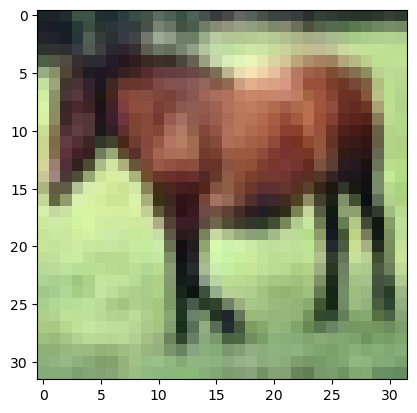

In [ ]:
# TODO: print more pictures
def print_class_plot_img(img_nbr:int)->None:
    print(label_to_class[y_train_valid[img_nbr].item()])
    plt.imshow(X_train_valid[img_nbr])

print_class_plot_img(img_nbr = 7)

**Note**: The images have a low resolution

# Feature engineering
* extract feature with pretrained models
* compare features extracted at different levels
* show top features by label

## Extact features from images
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- https://keras.io/api/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19
- https://keras.io/api/applications/#usage-examples-for-image-classification-models


In [7]:
IMG_SIZE = 160 # origninal img size (32, 32, 3), optimal img size (224, 224, 3)

### Feature extractor

In [ ]:
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model

# Load the model without the fully connected layer 
backbone: Model = MobileNetV2(
    weights="imagenet", 
    include_top=False, pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
backbone.trainable = False

# Build the feature extractor
# TODO: add angmenation layer:keras.layers.RandomTranslation etc
feature_extractor: Model = tf.keras.Sequential()
feature_extractor.add(keras.layers.Input(shape=(32, 32, 3), dtype=tf.uint8))
feature_extractor.add(keras.layers.Resizing(IMG_SIZE, IMG_SIZE, interpolation="bilinear"))
feature_extractor.add(keras.layers.Lambda(lambda x: preprocess_input(tf.cast(x, tf.float32))))
feature_extractor.add(backbone)

# Extract features
feat_train: np.ndarray = feature_extractor.predict(X_train, batch_size=256, verbose=0)  # (N_train, 1280)
feat_valid: np.ndarray = feature_extractor.predict(X_valid, batch_size=256, verbose=0)  # (N_valid, 1280)
feat_test: np.ndarray  = feature_extractor.predict(X_test,  batch_size=256, verbose=0)  # (N_test, 1280)

# Debug prints
print("Type of feat_train:", type(feat_train))
print("Shape of feat_train:", feat_train.shape)
print("feat_train dtype (expected: float32 by default):", feat_train.dtype)

print("Type of feat_valid:", type(feat_valid))
print("Shape of feat_valid:", feat_valid.shape)
print("feat_valid dtype (expected: float32 by default):", feat_valid.dtype)

print("Type of feat_test:", type(feat_test))
print("Shape of feat_test:", feat_test.shape)
print("feat_test dtype (expected: float32 by default):", feat_train.dtype)

Type of feat_train: <class 'numpy.ndarray'>
Shape of feat_train: (40000, 1280)
Type of feat_valid: <class 'numpy.ndarray'>
Shape of feat_valid: (10000, 1280)
Type of feat_test: <class 'numpy.ndarray'>
Shape of feat_test: (10000, 1280)


### Save features

In [8]:
from pathlib import Path

# Path to ../features relative to current working directory
features_dir: Path = (Path.cwd() / ".." / "features").resolve()
features_dir.mkdir(exist_ok=True)

In [ ]:
# Labels: flatten to 1-D
y_train_1d: np.ndarray = np.asarray(y_train).ravel().astype(np.int64)
y_valid_1d: np.ndarray = np.asarray(y_valid).ravel().astype(np.int64)
y_test_1d:  np.ndarray = np.asarray(y_test).ravel().astype(np.int64)

# Save the features and metadata as a single compressed NPZ
out_path = features_dir / f"mobilenetv2_{IMG_SIZE}_features.npz"
np.savez_compressed(
    file = out_path,
    feat_train=feat_train,
    feat_valid=feat_valid,
    feat_test=feat_test,
    y_train=y_train_1d,
    y_valid=y_valid_1d,
    y_test=y_test_1d,
    backbone=np.array(["MobileNetV2"], dtype=object),
    img_size=np.array([IMG_SIZE], dtype=np.int32),
    dtype=np.array([str(feat_train.dtype)], dtype=object),
)
print("Saved to:", out_path)

Saved to: /mnt/c/Users/aelgu.adyx/Documents/unibe/m1_2_prj_cas_aml/features/mobilenetv2_160_features.npz


# Models training
* Dummy classify
* On the fly data augmentation
* Baseline model: logistic regression
* comparison with random forest
* hyperparameter tuning: GridsearchCV

## Load features

In [9]:
# Load features and labels from file
bundle = np.load(features_dir / f"mobilenetv2_{IMG_SIZE}_features.npz", allow_pickle=True)

# Take features (vectors) and labels
feat_train = bundle["feat_train"]
feat_valid = bundle["feat_valid"]
feat_test  = bundle["feat_test"]
y_train_1d = bundle["y_train"]
y_valid_1d = bundle["y_valid"]
y_test_1d  = bundle["y_test"]

# Print shape and dtype for check
print("feat_train:", feat_train.shape, feat_train.dtype)
print("feat_valid:", feat_valid.shape, feat_valid.dtype)
print("feat_test :", feat_test.shape,  feat_test.dtype)
print("y_train  :", y_train_1d.shape, y_train_1d.dtype)
print("y_valid  :", y_valid_1d.shape, y_valid_1d.dtype)
print("y_test   :", y_test_1d.shape,  y_test_1d.dtype)

feat_train: (40000, 1280) float32
feat_valid: (10000, 1280) float32
feat_test : (10000, 1280) float32
y_train  : (40000,) int64
y_valid  : (10000,) int64
y_test   : (10000,) int64


## Sklearn models

### Import sklearn packages

In [39]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

### Helper function

In [60]:
# TODO: update the annotation type
def report(clf, X: np.ndarray, y: np.ndarray, name: str="Model")->None:
    # clf.fit(Xtr, ytr)
    y_predicted = clf.predict(X)
    print(f"[{name}] Accuracy:", accuracy_score(y, y_predicted))
    print(classification_report(y, y_predicted, digits=4))
    return None

### Dummy classifier

In [61]:
# TODO: add the annotation type
# Create a baseline with dummy classifier to compare with other models
# The uniform strategy: ignores the data and just picks a label at random, with equal probability for each class.
dummy_clf: DummyClassifier  = DummyClassifier(strategy="uniform") 
dummy_clf.fit(feat_train, y_train_1d)

# Evaluate on validation features (2D)
report(
    clf=dummy_clf,
    X=feat_valid, 
    y=y_valid_1d,
    name="Dummy classifier"
)

[Dummy classifier] Accuracy: 0.1016
              precision    recall  f1-score   support

           0     0.0939    0.0956    0.0948       973
           1     0.0908    0.0899    0.0903       979
           2     0.0955    0.0942    0.0948      1030
           3     0.1015    0.1017    0.1016      1023
           4     0.1125    0.1190    0.1156       933
           5     0.1104    0.1123    0.1113      1015
           6     0.1007    0.1004    0.1006       996
           7     0.0958    0.0966    0.0962       994
           8     0.1197    0.1121    0.1158      1017
           9     0.0958    0.0952    0.0955      1040

    accuracy                         0.1016     10000
   macro avg     0.1017    0.1017    0.1016     10000
weighted avg     0.1016    0.1016    0.1016     10000



**Note**: 
* Any models that actually learns should beat the current performance.
* The classes are well balanced. They are all very close to the 1/10.

### Logistic regression

In [37]:
# Logistic Regression (multiclass) + standardization
lr_clf: Pipeline = make_pipeline(
    StandardScaler(),  # scale features improves LR convergence
    LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",          # supports multinomial + n_jobs
        max_iter=500,
        n_jobs=-1,
        random_state=42,
    )
)

# Train on feature vectors (2D)
lr_clf.fit(feat_train, y_train_1d)

# Evaluate on validation features (2D)
report(
    clf=lr_clf,
    X=feat_valid, 
    y=y_valid_1d,
    name="Logistic Regression"
)

[Logistic Regression] Accuracy: 0.8272
              precision    recall  f1-score   support

           0     0.8325    0.8273    0.8299       973
           1     0.9079    0.9162    0.9120       979
           2     0.8024    0.7689    0.7853      1030
           3     0.7216    0.7019    0.7116      1023
           4     0.7639    0.8114    0.7869       933
           5     0.7740    0.7557    0.7647      1015
           6     0.8634    0.8695    0.8664       996
           7     0.8312    0.8370    0.8341       994
           8     0.8790    0.8859    0.8825      1017
           9     0.8907    0.9010    0.8958      1040

    accuracy                         0.8272     10000
   macro avg     0.8267    0.8275    0.8269     10000
weighted avg     0.8268    0.8272    0.8269     10000



### Random forest

In [40]:
# Random Forest classifier
rf_clf: RandomForestClassifier = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=None,        # let trees expand fully (or set e.g. 20)
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",   # good default for classification
    bootstrap=True,
    n_jobs=-1,             # use all cores
    random_state=42,
)

# Train on feature vectors
rf_clf.fit(feat_train, y_train_1d)

# Evaluate on valid features
report(clf=rf_clf, 
       X=feat_valid, 
       y=y_valid_1d, 
       name="Random forest")

[Random forest] Accuracy: 0.8184
              precision    recall  f1-score   support

           0     0.8172    0.8088    0.8130       973
           1     0.8943    0.9244    0.9091       979
           2     0.8513    0.7282    0.7849      1030
           3     0.6733    0.6911    0.6821      1023
           4     0.7405    0.8167    0.7768       933
           5     0.7765    0.7360    0.7557      1015
           6     0.8669    0.8896    0.8781       996
           7     0.8326    0.8058    0.8190       994
           8     0.8427    0.8958    0.8684      1017
           9     0.8940    0.8923    0.8932      1040

    accuracy                         0.8184     10000
   macro avg     0.8190    0.8189    0.8180     10000
weighted avg     0.8193    0.8184    0.8180     10000



### SVM

In [ ]:
svm_clf: Pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(dual=False, C=1.0, max_iter=5000, random_state=42)
)

svm_clf.fit(feat_train, y_train_1d)

# Evaluate on valid features
report(clf=svm_clf, 
       X=feat_valid, 
       y=y_valid_1d, 
       name="SVM")

[SVM] Accuracy: 0.8429
              precision    recall  f1-score   support

           0     0.8422    0.8499    0.8460       973
           1     0.8805    0.9030    0.8916       979
           2     0.8545    0.7922    0.8222      1030
           3     0.7485    0.7185    0.7332      1023
           4     0.7973    0.8349    0.8157       933
           5     0.8032    0.7842    0.7936      1015
           6     0.8898    0.8996    0.8947       996
           7     0.8516    0.8773    0.8642       994
           8     0.8841    0.8850    0.8845      1017
           9     0.8717    0.8885    0.8800      1040

    accuracy                         0.8429     10000
   macro avg     0.8423    0.8433    0.8426     10000
weighted avg     0.8425    0.8429    0.8424     10000



## Tensorflow/keras models


### Import tensorflow/keras packages

In [16]:
import tensorflow as tf

keras = tf.keras
layers = keras.layers
regularizers = keras.regularizers
callbacks = keras.callbacks

# from tensorflow import keras
# from tensorflow.python.keras import layers, regularizers, callbacks

# from tensorflow import keras
# from tensorflow.keras import layers, regularizers, callbacks


### Dense model

In [17]:
l2: float = 5e-4

# Fully connected classifier model (feedforward)
fc_clf: keras.Sequential = keras.Sequential([
    keras.Input(shape=(feat_train.shape[1],)),

    layers.Dropout(0.25), # TODO: is it necessary?

    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax"),
])

fc_clf.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# TODO: explain
cbs: list = [
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
]

history: keras.callbacks.History = fc_clf.fit(
    feat_train, y_train_1d,
    validation_data=(feat_valid, y_valid_1d),  # use real validation set
    epochs=150,
    batch_size=256,
    callbacks=cbs,
    verbose=1,
)


print("Test accuracy:", fc_clf.evaluate(feat_test, y_test_1d, verbose=0)[1])

2025-09-17 11:17:48.928685: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/150
157/157 [==============================] - 15s 69ms/step - loss: 2.1417 - accuracy: 0.4814 - val_loss: 1.1919 - val_accuracy: 0.8023 - lr: 0.0010
Epoch 2/150
157/157 [==============================] - 7s 44ms/step - loss: 1.3050 - accuracy: 0.7557 - val_loss: 0.9913 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 3/150
157/157 [==============================] - 9s 59ms/step - loss: 1.1427 - accuracy: 0.7960 - val_loss: 0.9108 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 4/150
157/157 [==============================] - 11s 67ms/step - loss: 1.0379 - accuracy: 0.8093 - val_loss: 0.8388 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 5/150
157/157 [==============================] - 6s 41ms/step - loss: 0.9567 - accuracy: 0.8210 - val_loss: 0.7936 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 6/150
157/157 [==============================] - 9s 58ms/step - loss: 0.8979 - accuracy: 0.8251 - val_loss: 0.7320 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 7/150
157/157 [==============================] - 9

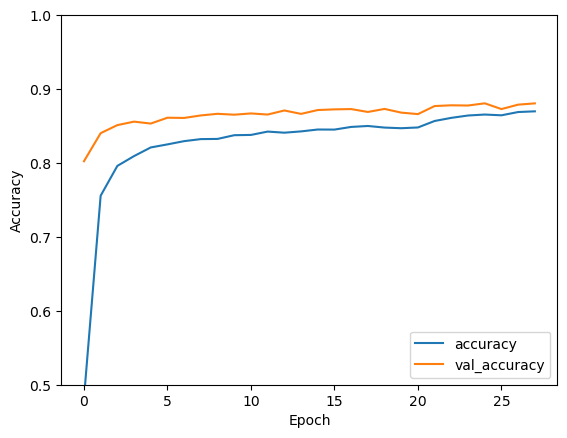

In [ ]:
# TODO: plot in parallel
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

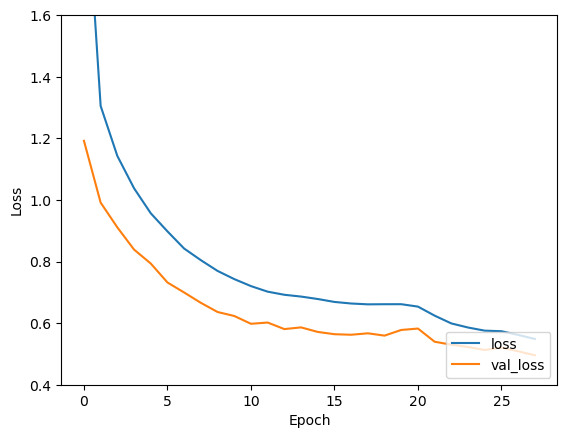

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.4, 1.6])
plt.legend(loc='lower right')

In [ ]:
# Predict class indices
# TODO: change code and use trained mdoel to predict
y_prob = fc_clf.predict(feat_valid, batch_size=1024, verbose=0)
y_pred_fc = np.argmax(y_prob, axis=1)

# (optional) CIFAR-10 class names
CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

print("Test accuracy (recomputed):", accuracy_score(y_valid_1d, y_pred_fc))
print(classification_report(y_valid_1d, y_pred_fc, digits=4, target_names=CLASS_NAMES))


Test accuracy (recomputed): 0.8807
              precision    recall  f1-score   support

    airplane     0.9020    0.8798    0.8907       973
  automobile     0.9265    0.9530    0.9396       979
        bird     0.8896    0.8369    0.8624      1030
         cat     0.7512    0.7967    0.7732      1023
        deer     0.8314    0.8671    0.8489       933
         dog     0.8556    0.7882    0.8205      1015
        frog     0.9126    0.9227    0.9176       996
       horse     0.9074    0.8974    0.9024       994
        ship     0.9036    0.9499    0.9262      1017
       truck     0.9335    0.9183    0.9258      1040

    accuracy                         0.8807     10000
   macro avg     0.8814    0.8810    0.8807     10000
weighted avg     0.8814    0.8807    0.8806     10000



In [62]:
# Predict class indices
y_prob = fc_clf.predict(feat_test, batch_size=1024, verbose=0)
y_pred_fc = np.argmax(y_prob, axis=1)

# (optional) CIFAR-10 class names
CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

print("Test accuracy (recomputed):", accuracy_score(y_test_1d, y_pred_fc))
print(classification_report(y_test_1d, y_pred_fc, digits=4, target_names=CLASS_NAMES))

Test accuracy (recomputed): 0.8742
              precision    recall  f1-score   support

    airplane     0.8992    0.8740    0.8864      1000
  automobile     0.9214    0.9380    0.9296      1000
        bird     0.8550    0.8490    0.8520      1000
         cat     0.7474    0.7870    0.7667      1000
        deer     0.8413    0.8320    0.8366      1000
         dog     0.8612    0.7940    0.8262      1000
        frog     0.8930    0.9260    0.9092      1000
       horse     0.9110    0.8800    0.8952      1000
        ship     0.8929    0.9420    0.9168      1000
       truck     0.9246    0.9200    0.9223      1000

    accuracy                         0.8742     10000
   macro avg     0.8747    0.8742    0.8741     10000
weighted avg     0.8747    0.8742    0.8741     10000



# Results and interpretations

## Error analysis

In [64]:
# Results form the best model
report_dict = classification_report(
    y_test_1d, y_pred_fc,
    digits=4,
    target_names=CLASS_NAMES,
    output_dict=True
)

print(report_dict)


error_rates = {}
for cls in CLASS_NAMES:
    recall = report_dict[cls]["recall"]     # per-class recall = correct/total for that class
    error_rates[cls] = 1.0 - recall

print("Error rate per class:")
for cls in CLASS_NAMES:
    print(f"{cls}: {error_rates[cls]:.4f}")

{'airplane': {'precision': 0.8991769547325102, 'recall': 0.874, 'f1-score': 0.8864097363083164, 'support': 1000.0}, 'automobile': {'precision': 0.9214145383104125, 'recall': 0.938, 'f1-score': 0.929633300297324, 'support': 1000.0}, 'bird': {'precision': 0.8549848942598187, 'recall': 0.849, 'f1-score': 0.8519819367787256, 'support': 1000.0}, 'cat': {'precision': 0.7473884140550807, 'recall': 0.787, 'f1-score': 0.76668290306868, 'support': 1000.0}, 'deer': {'precision': 0.8412537917087968, 'recall': 0.832, 'f1-score': 0.8366013071895425, 'support': 1000.0}, 'dog': {'precision': 0.8611713665943601, 'recall': 0.794, 'f1-score': 0.826222684703434, 'support': 1000.0}, 'frog': {'precision': 0.892960462873674, 'recall': 0.926, 'f1-score': 0.9091801669121257, 'support': 1000.0}, 'horse': {'precision': 0.9109730848861284, 'recall': 0.88, 'f1-score': 0.8952187182095626, 'support': 1000.0}, 'ship': {'precision': 0.8928909952606635, 'recall': 0.942, 'f1-score': 0.9167883211678832, 'support': 1000.0

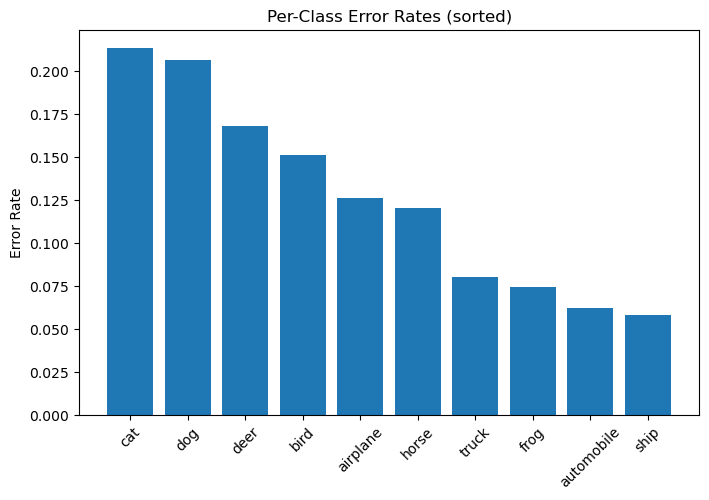

In [65]:
# Sort error_rates by value (descending)
sorted_items = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

# Unpack keys and values
classes_sorted = [cls for cls, _ in sorted_items]
errors_sorted  = [err for _, err in sorted_items]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(classes_sorted, errors_sorted)
plt.xticks(rotation=45)
plt.ylabel("Error Rate")
plt.title("Per-Class Error Rates (sorted)")
plt.show()